# Project 6: Hourly Energy Consumption

### Brief Project Description

In this project, we use hourly time-series data on energy consumption to predict future values for one year in advance. The model that we build in this project employs the XGBoost algorithm.

__Agenda Points of what we want to do within this project:__
 
 * **Find trends in energy consumption around hours of the day, holidays, or long term trends?**
 * **Understand how daily trends change depending of the time of year.** 
 * **Build a model to predict energy consumption for a forecasting window of one year.**


The dataset and a detailed description of the variables can be found at the following URL: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?select=AEP_hourly.csv

### Data Import and first Inspection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from feature_engine.creation import CyclicalFeatures

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [2]:
# import and inspect the data
df = pd.read_csv('AEP_hourly.csv', parse_dates = ['Datetime'], index_col='Datetime').sort_index()
df.head()

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


In [3]:
# show columns
print(f'Columns of the data frame {df.columns}\n')

# rename columns
df = df.rename({'Datetime': 'Datetime', 'AEP_MW': 'Megawatt Energy Consumption'}, axis=1)
display(df.head())

# eliminate duplicates in the timeindex variable
df = df[~df.index.duplicated()]

# check dataframe for missing values
print(f'Number of missing values: {df.isna().sum().values[0]}')

# check for missing time stamps
data = df.asfreq('H')
data_imputed = data.fillna(method='ffill')
print(f'Number of missing time stamps: {data_imputed.isnull().sum().values[0]}')

Columns of the data frame Index(['AEP_MW'], dtype='object')



,Megawatt Energy Consumption
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


Number of missing values: 0
Number of missing time stamps: 0


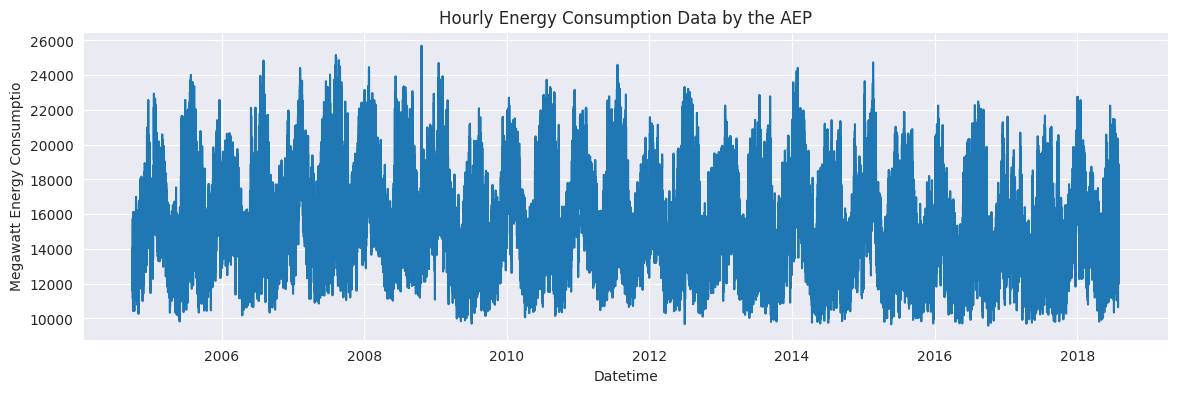

In [4]:
# plot the time series 
sns.set_style("darkgrid")
plt.figure(figsize=(14,4), dpi=100)
plt.rcParams.update({'font.size':10})

sns.lineplot(data=df,x='Datetime', y='Megawatt Energy Consumption')  
plt.title("Hourly Energy Consumption Data by the AEP")
plt.xlabel("Datetime")
plt.ylabel("Megawatt Energy Consumptio"); 

Here, we observe a pattern within each year, indicating a seasonal effect. Moreover, we observe that there is no clear trend in an upward or downward direction; we refer to it as a horizontal or stationary trend.

## Feature engineering

These are features that capture information from the timestamp.

In [5]:
# capture information from the timestamp
df["Hour of the Day"]= df.index.hour 
df["Day"] = df.index.day
df["Day_of_Week"]= df.index.dayofweek
df["Day_Name"]= df.index.day_name()
df["Month"]= df.index.month
df['Quarter'] = df.index.quarter
df["Year"]= df.index.year

# find out, if it is weekend
df["Is_Weekend"]= np.where(df["Day_of_Week"]>4,1,0)

df.head()

,Megawatt Energy Consumption,Hour of the Day,Day,Day_of_Week,Day_Name,Month,Quarter,Year,Is_Weekend
Datetime,,,,,,,,,
2004-10-01 01:00:00,12379.0,1,1,4,Friday,10,4,2004,0
2004-10-01 02:00:00,11935.0,2,1,4,Friday,10,4,2004,0
2004-10-01 03:00:00,11692.0,3,1,4,Friday,10,4,2004,0
2004-10-01 04:00:00,11597.0,4,1,4,Friday,10,4,2004,0
2004-10-01 05:00:00,11681.0,5,1,4,Friday,10,4,2004,0


### Lag features

Lag features are past values of the variables that we can use to predict future values.

I will use the following lag features to predict the sales for the next week.
  * The amount of sales for the previous week (t-1)
  * The amount of sales for the previous month (t-4)

In [6]:
freq_list = ['1H', '4H']
variable =['Megawatt Energy Consumption']

def set_lag_feat(variable, freq_list, df):
    for freq_value in freq_list:
        
        # shift the data foward one week
        temp = df[variable].shift(freq=freq_value)
        
        # names for the new variable
        temp.columns = [v  +"_lag_" + freq_value for v in variable]
        
        # add variables to the original data
        print("data size before")
        print(df.shape)
        
        df = df.merge(temp, left_index=True, right_index=True, how='left')
        
        print("data size after")
        print(df.shape)
        
    return df

df = set_lag_feat(variable, freq_list, df)
df.head()

data size before
(121269, 9)
data size after
(121269, 10)
data size before
(121269, 10)
data size after
(121269, 11)


,Megawatt Energy Consumption,Hour of the Day,Day,Day_of_Week,Day_Name,Month,Quarter,Year,Is_Weekend,Megawatt Energy Consumption_lag_1H,Megawatt Energy Consumption_lag_4H
Datetime,,,,,,,,,,,
2004-10-01 01:00:00,12379.0,1,1,4,Friday,10,4,2004,0,NaN,NaN
2004-10-01 02:00:00,11935.0,2,1,4,Friday,10,4,2004,0,12379.0,NaN
2004-10-01 03:00:00,11692.0,3,1,4,Friday,10,4,2004,0,11935.0,NaN
2004-10-01 04:00:00,11597.0,4,1,4,Friday,10,4,2004,0,11692.0,NaN
2004-10-01 05:00:00,11681.0,5,1,4,Friday,10,4,2004,0,11597.0,12379.0


### Window Features

Window features are mathematical computations of the feature values of a predefined time window, prior to the time we want to forecast.

In [7]:
# use the mean of the 3 prevous weeks as an input variable
temp = df[variable].rolling(window='3H').mean().shift(freq='1H')

# rename the column
temp.columns = [v +'_window' for v in variable]

# view of the result
temp.head()

,Megawatt Energy Consumption_window
Datetime,
2004-10-01 02:00:00,12379.000000
2004-10-01 03:00:00,12157.000000
2004-10-01 04:00:00,12002.000000
2004-10-01 05:00:00,11741.333333
2004-10-01 06:00:00,11656.666667


In [8]:
# join the new variables to the original data
df = df.merge(temp, left_index=True, right_index=True, how='left')
df[["Megawatt Energy Consumption", "Megawatt Energy Consumption_window"]].head()

,Megawatt Energy Consumption,Megawatt Energy Consumption_window
Datetime,,
2004-10-01 01:00:00,12379.0,NaN
2004-10-01 02:00:00,11935.0,12379.000000
2004-10-01 03:00:00,11692.0,12157.000000
2004-10-01 04:00:00,11597.0,12002.000000
2004-10-01 05:00:00,11681.0,11741.333333


### Periodic Features

Some features as month, quarter, day and hour are periodic. However the periodic nature of those features is not catured in a numeric representation. In this section we capture the periodic nature of those features in a numeric representation by using sine and cosine transformation with the features period.

In [9]:
cyclical = CyclicalFeatures(variables=['Quarter','Month', 'Day', 'Hour of the Day'], drop_original=False)

df = cyclical.fit_transform(df)

cyclical_vars = [v for v in df.columns if 'sin' in v or 'cos' in v]

df[cyclical_vars].head()

,Quarter_sin,Quarter_cos,Month_sin,Month_cos,Day_sin,Day_cos,Hour of the Day_sin,Hour of the Day_cos
Datetime,,,,,,,,
2004-10-01 01:00:00,-2.449294e-16,1.0,-0.866025,0.5,0.201299,0.97953,0.269797,0.962917
2004-10-01 02:00:00,-2.449294e-16,1.0,-0.866025,0.5,0.201299,0.97953,0.519584,0.854419
2004-10-01 03:00:00,-2.449294e-16,1.0,-0.866025,0.5,0.201299,0.97953,0.730836,0.682553
2004-10-01 04:00:00,-2.449294e-16,1.0,-0.866025,0.5,0.201299,0.97953,0.887885,0.460065
2004-10-01 05:00:00,-2.449294e-16,1.0,-0.866025,0.5,0.201299,0.97953,0.979084,0.203456


### Drop missing data

When creating lag and window features, we introduced missing values. So we have to get rid of that missing values.

In [10]:
df.isnull().sum()

Megawatt Energy Consumption            0
Hour of the Day                        0
Day                                    0
Day_of_Week                            0
Day_Name                               0
Month                                  0
Quarter                                0
Year                                   0
Is_Weekend                             0
Megawatt Energy Consumption_lag_1H    28
Megawatt Energy Consumption_lag_4H    31
Megawatt Energy Consumption_window    28
Quarter_sin                            0
Quarter_cos                            0
Month_sin                              0
Month_cos                              0
Day_sin                                0
Day_cos                                0
Hour of the Day_sin                    0
Hour of the Day_cos                    0
dtype: int64

In [11]:
df.dropna(inplace=True)

## Detecting Seasonal Trends

Since we have features derived from the time index variable, this enables us to detect trends in our data based on time-related features like the day of the week, month, quarter, and so forth.

__Average Megawatt Energy Consumption by Year__

We begin with the year variable and plot the average megawatt energy consumption for each year to identify trends. We only consider years for which we have data for the entire year. This means we exclude data for the years 2004 and 2018 because it is incomplete.

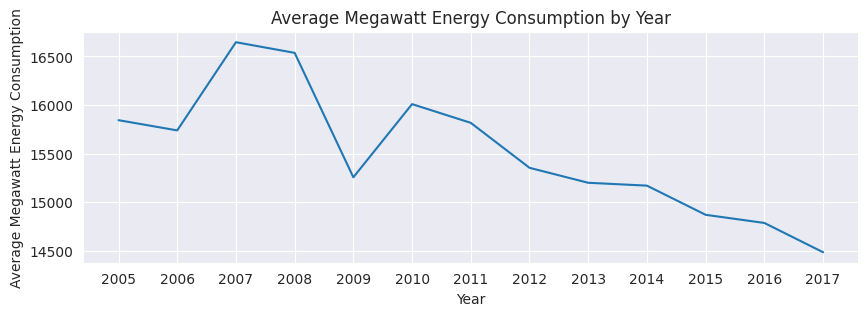

In [12]:
# prepare the data for plotting
df_year = df.groupby('Year')["Megawatt Energy Consumption"].mean().to_frame().reset_index()
df_year = df_year[(df_year["Year"]!=2004) & (df_year["Year"]!=2018)]

# create a line plot
plt.figure(figsize=(10,3), dpi=100)
plt.rcParams.update({'font.size':10})
sns.lineplot(data=df_year ,x='Year', y="Megawatt Energy Consumption")
plt.xticks(np.arange(2005,2018,1))
plt.title("Average Megawatt Energy Consumption by Year")
plt.ylabel('Average Megawatt Energy Consumption')
plt.xlabel("Year");

Contrary to our initial intuition, where we identified a stationary trend, we now observe a decline in the average energy consumption over the years.

__Average Megawatt Energy Consumption by Month__

After examining long-term trends, we will search for recurring patterns within a shorter fixed time period. We set this fixed time period to one year. By plotting individual graphs for each year, we aim to identify evidence of repeating patterns.

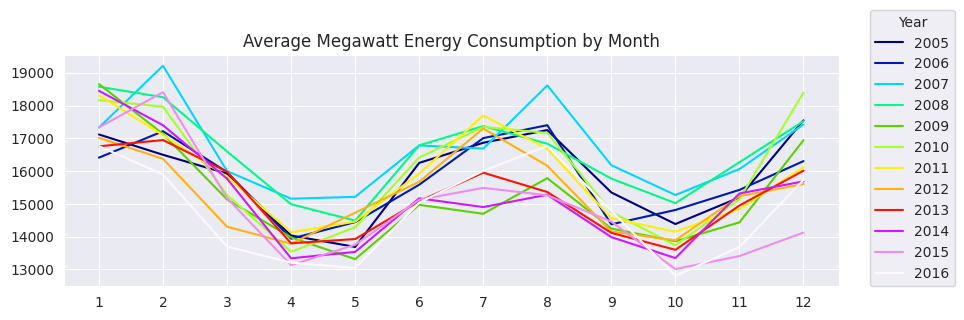

In [13]:
# prepare the data for plotting
data_year = df.groupby(["Month","Year"])['Megawatt Energy Consumption'].mean().to_frame().reset_index() 
fig, ax = plt.subplots(1,1,figsize=(10,3), dpi=100)
plt.rcParams.update({'font.size':10})

# create a line plot for each year
for year in np.arange(2005,2017):
    monthes = data_year[data_year['Year']==year]['Month']
    energy_consumption = data_year[data_year['Year']==year]['Megawatt Energy Consumption']
    ax.plot(monthes,energy_consumption )
    ax.set_xticks(np.arange(1,13,1))
    ax.set_title("Average Megawatt Energy Consumption by Month")

# create a colormap and assign colors to it
colormap = plt.cm.gist_ncar
colors = [colormap(i) for i in np.linspace(0, 1,len(ax.lines))]   

# assign a unique color to each lineplot
for i,j in enumerate(ax.lines):
    j.set_color(colors[i])

ax.legend(np.arange(2005,2017), loc=(1.04, 0), title='Year')
plt.show()


We can clearly see that peaks in the graphs occur during winter and summer months, while lows are in the spring or autumn months. This suggests that we should expect the highest energy consumption during summer and winter.

__Average Megawatt Energy Consumption by Day and Day of the Week__

Another question we would like to address is how energy consumption is distributed throughout the hours of the day. Additionally, we aim to identify any differences in energy consumption between the days of the week.

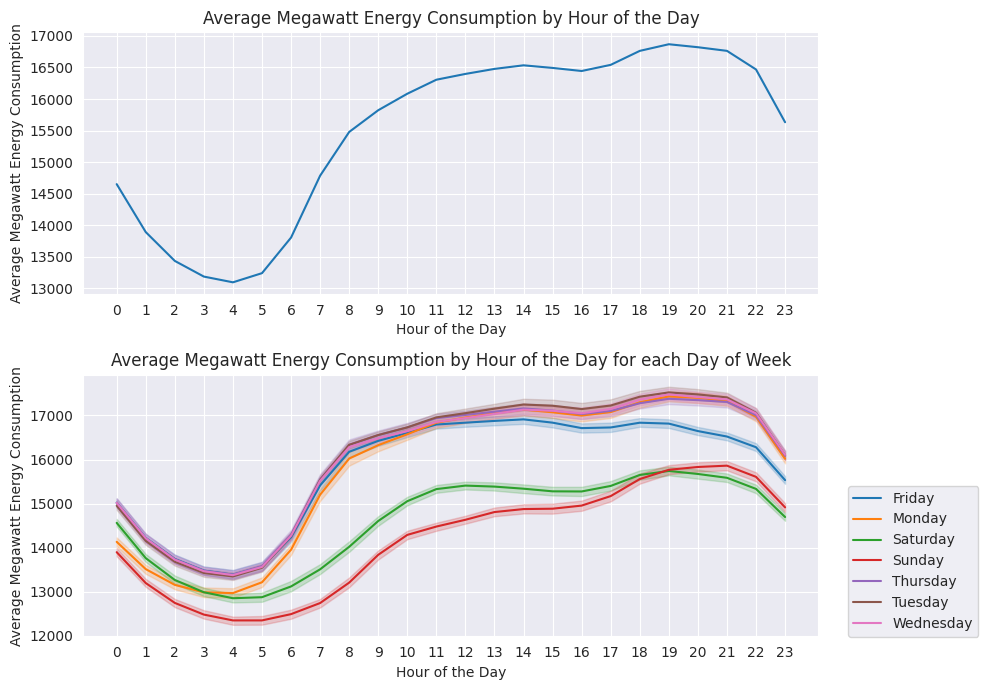

In [14]:
# prepare the data for plotting
series1 = df.groupby("Hour of the Day")['Megawatt Energy Consumption'].mean()
series_days = df.groupby(["Hour of the Day", "Day", "Day_Name"])['Megawatt Energy Consumption'].mean()
df_days = series_days.to_frame().reset_index()


# plot the average megawatt energy consumption by hour for a day
plt.figure(figsize=(10,7), dpi=100)
plt.rcParams.update({'font.size':10})

plt.subplot(211)
sns.lineplot(x=series1.index, y= series1.values)
plt.title("Average Megawatt Energy Consumption by Hour of the Day")
plt.xticks(series1.index)
plt.ylabel('Average Megawatt Energy Consumption')
plt.xlabel("Hour of the Day");

# plot the average megawatt energy consumption by Hour for all days of the week
plt.subplot(212)
sns.lineplot(data=df_days, x="Hour of the Day", y='Megawatt Energy Consumption', hue="Day_Name")
plt.title("Average Megawatt Energy Consumption by Hour of the Day for each Day of Week")
plt.ylabel('Average Megawatt Energy Consumption')
plt.xlabel("Hour of the Day")
plt.xticks(series1.index)
plt.legend(loc=(1.04, 0))


plt.tight_layout()
plt.show()

## Train | Test Split 

Separate the data into training and testing sets. Since we aim to forecast one year in advance, we leave the data after the timestamp "2017-08-03 00:00:00" to evaluate the forecasts, which constitutes the testing set.

In [15]:
# drop categorical columns
df.drop(['Day_Name'], axis=1, inplace=True)
df.head()

,Megawatt Energy Consumption,Hour of the Day,Day,Day_of_Week,Month,Quarter,Year,Is_Weekend,Megawatt Energy Consumption_lag_1H,Megawatt Energy Consumption_lag_4H,Megawatt Energy Consumption_window,Quarter_sin,Quarter_cos,Month_sin,Month_cos,Day_sin,Day_cos,Hour of the Day_sin,Hour of the Day_cos
Datetime,,,,,,,,,,,,,,,,,,,
2004-10-01 05:00:00,11681.0,5,1,4,10,4,2004,0,11597.0,12379.0,11741.333333,-2.449294e-16,1.0,-0.866025,0.5,0.201299,0.97953,0.979084,0.203456
2004-10-01 06:00:00,12280.0,6,1,4,10,4,2004,0,11681.0,11935.0,11656.666667,-2.449294e-16,1.0,-0.866025,0.5,0.201299,0.97953,0.997669,-0.068242
2004-10-01 07:00:00,13692.0,7,1,4,10,4,2004,0,12280.0,11692.0,11852.666667,-2.449294e-16,1.0,-0.866025,0.5,0.201299,0.97953,0.942261,-0.334880
2004-10-01 08:00:00,14618.0,8,1,4,10,4,2004,0,13692.0,11597.0,12551.000000,-2.449294e-16,1.0,-0.866025,0.5,0.201299,0.97953,0.816970,-0.576680
2004-10-01 09:00:00,14903.0,9,1,4,10,4,2004,0,14618.0,11681.0,13530.000000,-2.449294e-16,1.0,-0.866025,0.5,0.201299,0.97953,0.631088,-0.775711


In [16]:
# define thee split date variable
split_date = df.index.max() - pd.DateOffset(years=1)

# create the training set
X_train = df.loc[df.index<=split_date].drop('Megawatt Energy Consumption', axis=1)
y_train = df.loc[df.index<=split_date]

# create the test set
X_test = df.loc[df.index > split_date].drop('Megawatt Energy Consumption', axis=1)
y_test = df.loc[df.index > split_date]

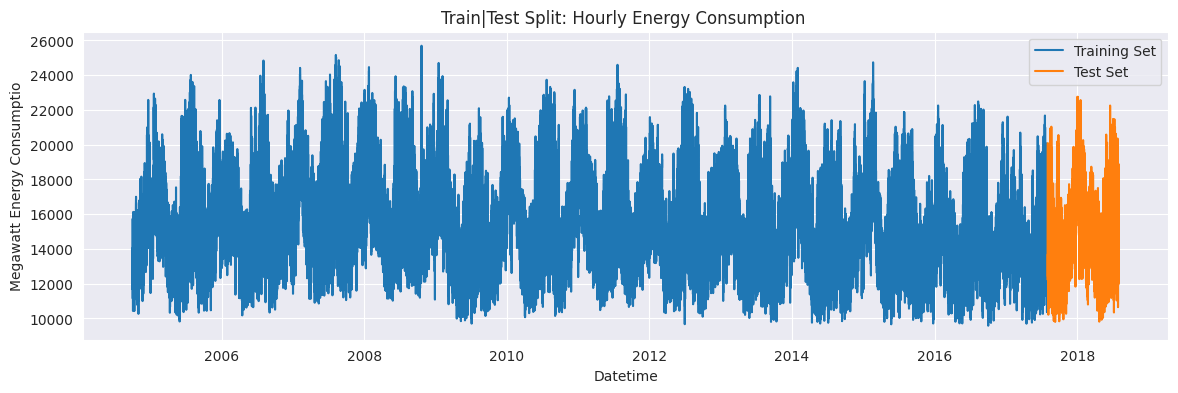

In [17]:
# plot the segments of the time series assigned as the training set and the test set using different colors.
sns.set_style("darkgrid")
plt.figure(figsize=(14,4), dpi=100)
plt.rcParams.update({'font.size':10})

# plot the training set
sns.lineplot(data=y_train ,x='Datetime', y='Megawatt Energy Consumption',label='Training Set')  
plt.title("Train|Test Split: Hourly Energy Consumption ")
plt.xlabel("Datetime")
plt.ylabel("Megawatt Energy Consumptio"); 

#Plot the test set
sns.lineplot(data=y_test ,x='Datetime', y='Megawatt Energy Consumption',label='Test Set');

## XGBoost Regressor

In [18]:
# create a XGBRegressor object
regressor = xgb.XGBRegressor(eval_metric='rmsle')

# we do a grid search to find the best hyperparameters
# since this type of grid search is somewhat time-consuming, we commented out the code for the grid search below

"""
#Set up our search grid
param_grid = {"max_depth": [4,5,6],
             "n_estimators": [500,600, 700],
            "learning_rate":[0.01, 0.015]}

serach = GridSearchCV(regressor, param_grid, cv=5).fit(X_train,y_train)

print('The best hyperparameters are:', serach.best_params_)
"""

# we obtaained the following best hyperparameters by running the grid_search:
# {'learning_rate': 0.015, 'max_depth': 6, 'n_estimators': 700}

# we use these values for our hyperparameters in our final calculation.
regressor = xgb.XGBRegressor(learning_rate=0.015,max_depth=6,n_estimators=700, eval_metric=mean_squared_error)
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

# print out the mean squared error
print(f'We obtain a mean_squared_error of {mean_squared_error(y_test,predictions, squared=False)}.')

We obtain a mean_squared_error of 8.671831770634395.


## Forcast on the Test Set

In the following, we plot the forecasts for the test set alongside its ground truth to visualize the quality of our predictions.

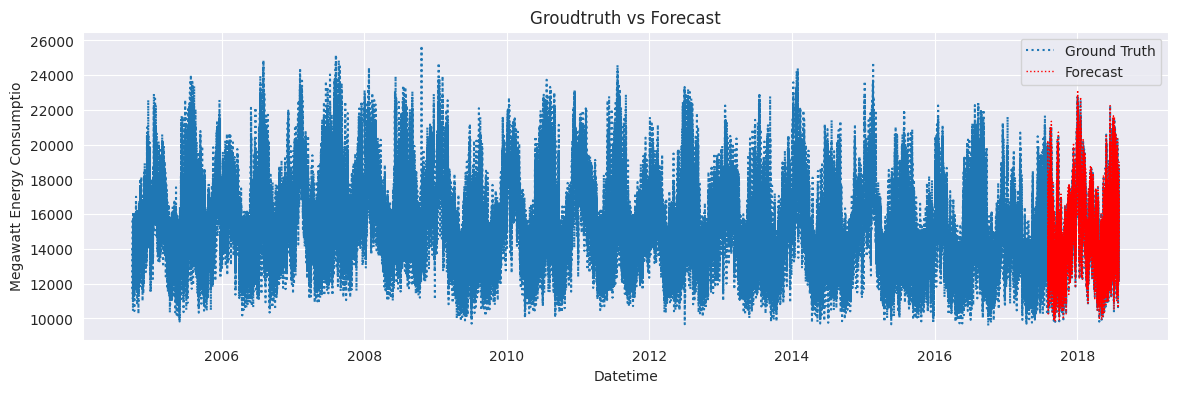

In [19]:
# prepare the data for plotting
X_test['Megawatt Energy Consumption Predictions'] = predictions[:,0]

# initialize the overall plot features
sns.set_style("darkgrid")
plt.figure(figsize=(14,4), dpi=100)
plt.rcParams.update({'font.size':10})

# plot the training set
sns.lineplot(data=df ,x='Datetime', y='Megawatt Energy Consumption',label='Ground Truth', linestyle='dotted')  
plt.title("Groudtruth vs Forecast")
plt.xlabel("Datetime")
plt.ylabel("Megawatt Energy Consumptio"); 

# plot the test set
sns.lineplot(data=X_test ,x='Datetime', y='Megawatt Energy Consumption Predictions',label='Forecast', 
             color='r', linestyle='dotted', linewidth=1);

Next, we plot two comparisons: First, forecasts for a time horizon of one month compared to their ground truth. Second, a forecast with a time horizon that covers only one week, alongside its ground truth.

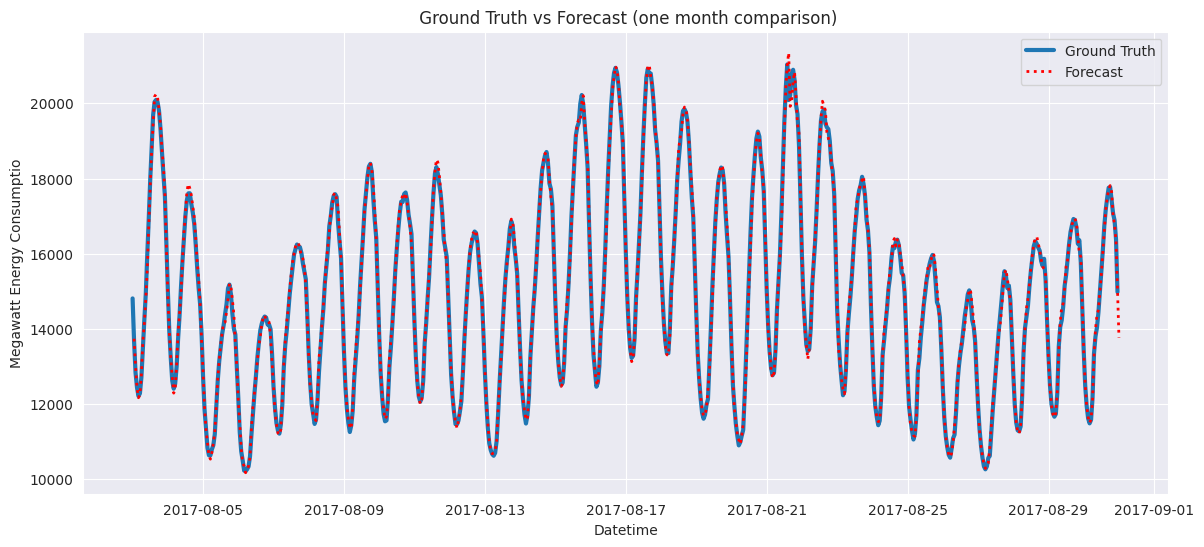

In [20]:
# prepare the data for plotting
forecast_window = split_date + pd.offsets.MonthEnd()
ground_truth_one_month = df.loc[(split_date <= df.index) & (df.index < forecast_window)]
forecast_one_month = X_test.loc[X_test.index <= forecast_window] 

# initialize the overall plot features
sns.set_style("darkgrid")
plt.figure(figsize=(14,6), dpi=100)
plt.rcParams.update({'font.size':10})

# plot the ground truth data
sns.lineplot(data=ground_truth_one_month ,x='Datetime', y='Megawatt Energy Consumption',
             label='Ground Truth', linewidth =3)  
plt.title(" Ground Truth vs Forecast (one month comparison)")
plt.xlabel("Datetime")
plt.ylabel("Megawatt Energy Consumptio"); 

# plot the forecast
sns.lineplot(data=forecast_one_month ,x='Datetime', y='Megawatt Energy Consumption Predictions',
             label='Forecast',linestyle='dotted', linewidth =2,color='r'); 


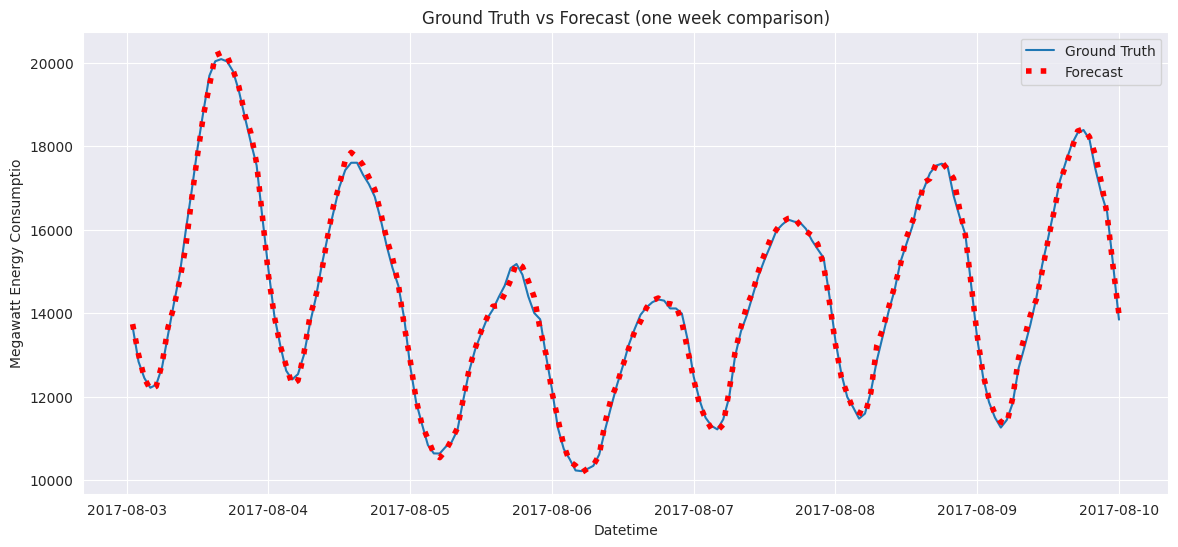

In [21]:
# prepare the data for plotting
forecast_window = split_date +pd.offsets.Week(1)
ground_truth_one_month = df.loc[(split_date<df.index) & (df.index<=forecast_window)]
forecast_one_month = X_test.loc[X_test.index<=forecast_window]

# initialize the overall plot features
sns.set_style("darkgrid")
plt.figure(figsize=(14,6), dpi=100)
plt.rcParams.update({'font.size':10})

# plot the ground truth data
sns.lineplot(data=ground_truth_one_month ,x='Datetime', y='Megawatt Energy Consumption',label='Ground Truth')  
plt.title("Ground Truth vs Forecast (one week comparison)")
plt.xlabel("Datetime")
plt.ylabel("Megawatt Energy Consumptio"); 

# plot the forecast
sns.lineplot(data=forecast_one_month ,x='Datetime', y='Megawatt Energy Consumption Predictions',
             label='Forecast',linestyle=':', linewidth =4, color='r');


## Features Importance

In this section, we aim to identify which features are the most important with respect to our forecast.

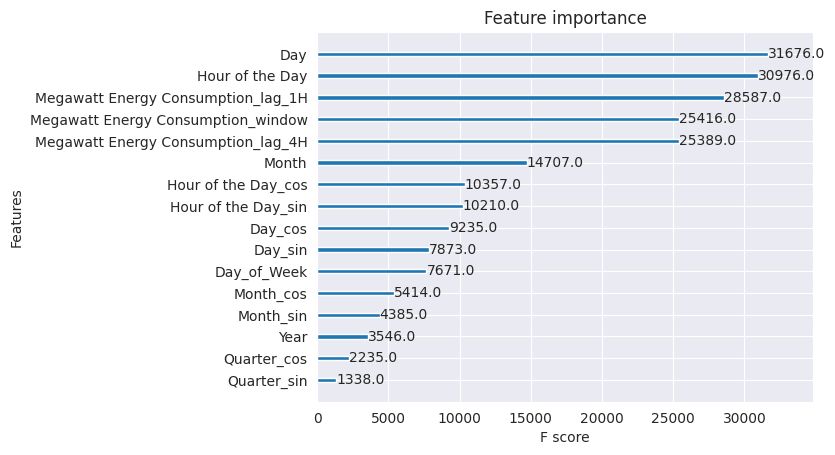

In [22]:
# let's plot the feature's importance
# according to the xgboost model

xgb.plot_importance(regressor)
plt.show();

## References

https://www.kaggle.com/code/saurav9786/time-series-tutorial